In [181]:
using GaussianRandomFields, PyPlot
using Random, Printf
using ArchGDAL; const AG = ArchGDAL
using LibPQ  # 用于连接数据库PostGIS
using DataFrames
using Query
using CSV
using Statistics

# 数据准备

任务目标：产生100个点的接收数据，并保存在表格中。

1.在空间设置100个监测点，1个发射信号源

2.利用高斯随机场，模拟100个点的接收信号功率，包括
    * 自由空间传播损耗的影响（直接计算）
    * 空间相关的阴影衰落（利用高斯随机场上的线积分生成）
    
3.每个点采集100个数据：由于阴影衰落的随机性，同一点每次采集的数据不一样，但总体数据必须符合阴影衰落的统计特性，且空间上具有相关性。

_利用postGIS数据库结合Julia的几个软件包完成上述任务_

## 连接数据库

In [30]:
conn = LibPQ.Connection("dbname=postgis_in_action user=postgres") # 连接数据库

PostgreSQL connection (CONNECTION_OK) with parameters:
  user = postgres
  passfile = /Users/sat/.pgpass
  dbname = postgis_in_action
  port = 5432
  client_encoding = UTF8
  options = -c DateStyle=ISO,YMD -c IntervalStyle=iso_8601 -c TimeZone=UTC
  application_name = LibPQ.jl
  sslmode = prefer
  sslcompression = 0
  gssencmode = disable
  target_session_attrs = any

## 在数据库中建立一个schema，用于存储项目相关的数据

In [33]:
execute(conn, """
    CREATE SCHEMA thesis1;
    """
)

PostgreSQL result

## 利用GaussianRandomFields产生高斯随机场


PyObject <matplotlib.colorbar.Colorbar object at 0x14c555a90>

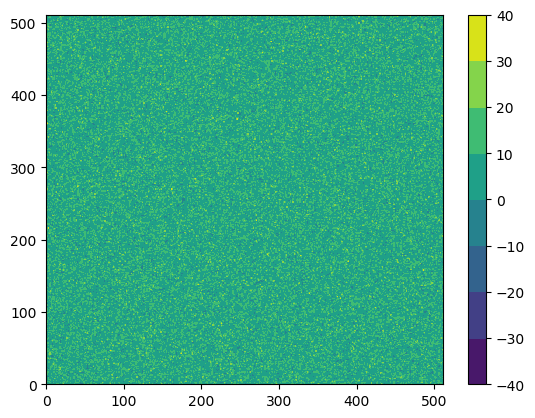

In [7]:
exp = Exponential(log(2)/20, σ=8,p=2) #Exponential(20; 8)
cov = CovarianceFunction(2,exp)
pts = 0:1:511
grf = GaussianRandomField(cov,CirculantEmbedding(),pts,pts)
display(contourf(grf))

## 用ArchGDAL产生100个TIF格式的raster文件

In [12]:
for i = 1:100
    random_field = sample(grf)
    name = "random_field_" * string(i,pad=4) * ".tif"
    AG.registerdrivers() do
        raster = AG.unsafe_create(
        name,
        AG.getdriver("GTiff"),
        width = 512,
        height = 512,
        nbands = 1,
        dtype = Float64
        )
        geotransform = [-0.5, 1.0, 0, 0.5, 0, -1]
        AG.setgeotransform!(raster, geotransform)
        AG.write!(
            raster,
            random_field,  # image to "burn" into the raster
            1,      # update band 1
        )
        AG.destroy(raster)
    end
end
## 512米×512米的范围内，生成的数据点为512*512,每间隔1米一个点

## 将100个tif文件以raster格式存入数据库
使用postgres的命令行工具：raster2pgsql，建立一个名为thesis1.raster_grf的表格，共三列（rid，rast，filename）

In [50]:
run(`raster2pgsql -s 2334 -C -F -t 512x512 *.tif -d thesis1.raster_grf | psql`)

┌ Warning: special characters "#{}()[]<>|&*?~;" should now be quoted in commands
│   caller = #shell_parse#353(::String, ::typeof(Base.shell_parse), ::String, ::Bool) at shell.jl:100
└ @ Base ./shell.jl:100
ERROR: Unable to read raster file: *.tif


ProcessFailedException: failed process: Process(`raster2pgsql -C -F -t 512x512 '*.tif' -d thesis1.raster_grf '|' psql`, ProcessExited(1)) [1]


##  编程目标
### 输入：
* 发送点的发送功率，空间坐标值
* 监测点的位置（可以调取数据库中的POINT集合）
### 输出：
一个数据集，行表示监测点，列表示不同时刻的接收功率
调用上面数据库中的raster生成一个数据集，用每行表示终端，列表示raster生成的接收信号强度

In [18]:
trans_coodinate_x = 232   # x取值范围为（0，500）
trans_coodinate_y = -310  # y取值范围为（-500，0）

30

## 用线积分的方法计算阴影衰落
利用发送点位置、监测点位置、高斯随机场，得出各个监测点的阴影衰落

#### 建立用于存放发射点坐标的表格

In [36]:
execute(conn, """
    CREATE TABLE thesis1.transmission (
    id serial PRIMARY KEY,
    x_cood float,
    y_cood float,
    pt geometry(POINT,2334) UNIQUE
    );
    """
)

PostgreSQL result

In [ ]:
LibPQ.load!(
    (a = [trans_coodinate_x], b = [trans_coodinate_y]),
    conn,
    """
    INSERT INTO thesis1.transmission(x_cood,y_cood, pt)
        VALUES (\$1, \$2, ST_SetSRID(ST_Point(\$1,\$2), 2334));
    """,
)

利用QGIS生成空间不同分布的点，这里先使用等间隔分布的点

每个观测点与 发射点连线，在高斯随机场做线积分

建立表格，用于存放监测点与发射点的连线，把连线变成间隔0.2米的线段

In [63]:
execute(conn,"""
    DROP TABLE IF EXISTS thesis1.regular_channel_lines_seg_temp;
    CREATE TABLE thesis1.regular_channel_lines_seg_temp (
        id serial PRIMARY KEY,
        recv_geom geometry(POINT,2334),
        trans_ID int,
        lines_seg geometry(LINESTRING,2334),
        FOREIGN KEY (trans_ID) REFERENCES thesis1.transmission(id)
    );
    """
)

PostgreSQL result

In [64]:
execute(conn,"""
    INSERT INTO thesis1.regular_channel_lines_seg_temp(id,recv_geom, trans_ID, lines_seg)
        SELECT r.id,
               r.geom,
               t.id,
               ST_Segmentize(ST_MakeLine(r.geom,t.pt), 0.2)
     FROM thesis1.regular_points AS r
          CROSS JOIN
          (SELECT id, pt FROM thesis1.transmission WHERE id=1) AS t
    ;
    """
)  ## 这里把监测点与信号源的连线，每间隔0.2米产生一个点，方便后面做线积分

PostgreSQL result

计算出监测点与信号源之间的距离插入上面的数据表中

In [93]:
execute(conn,"""
    ALTER TABLE thesis1.regular_channel_lines_seg_temp DROP COLUMN dist_to_tran;
    
""")

PostgreSQL result

把所有的线段变成点，在高斯随机场上找到每个点的取值，对每条线段上点的取值求和来近似表示在线段上求线积分
WHERE rid<100,可以用于控制产生多少组数据，每个高斯随机场的rid对应一组数据

In [84]:
execute(conn,"""
    DROP TABLE IF EXISTS thesis1.shadowloss_temp;
    CREATE TABLE thesis1.shadowloss_temp as
        SELECT
          trail.id,
          grf.rid,
          sum(ST_Value(rast,gd))
        FROM
          (SELECT
                id,
                (ST_DumpPoints(lines_seg)).geom as gd
           FROM
                thesis1.regular_channel_lines_seg_temp
          ) AS trail
          LEFT JOIN
            (SELECT
                 rid,
                 rast
             FROM
               thesis1.raster_grf
             WHERE rid<101) AS grf
          ON ST_Intersects(rast, trail.gd)
        GROUP BY trail.id, grf.rid;
"""
)

PostgreSQL result

## 数据库中几个表格预览

### 信号源位置表格

In [135]:
transmission = execute(conn,"""
    SELECT id,x_cood,y_cood,ST_AsText(pt) FROM thesis1.transmission
    ORDER BY id ASC LIMIT 6
    """)
DataFrame(transmission)

,id,x_cood,y_cood,st_astext
,Int32⍰,Float64⍰,Float64⍰,String⍰
1,1,232.0,-310.0,POINT(232 -310)


### 规则分布的点与发射点关系的表格

In [143]:
regular_channel_line = execute(conn,"""
    SELECT id,ST_AsText(recv_geom) AS regular_point,trans_id FROM thesis1.regular_channel_lines_seg_temp
    ORDER BY id ASC LIMIT 6
    """)
DataFrame(regular_channel_line)

,id,regular_point,trans_id
,Int32⍰,String⍰,Int32⍰
1,0,POINT(25 -25),1
2,1,POINT(75 -25),1
3,2,POINT(125 -25),1
4,3,POINT(175 -25),1
5,4,POINT(225 -25),1
6,5,POINT(275 -25),1


### 规则分布的点和发射点的连线，在不同的raster上求积分

In [146]:
shadowloss_temp = execute(conn,"""
    SELECT id ,rid AS raster,sum AS integrel_value FROM thesis1.shadowloss_temp
    ORDER BY id ASC LIMIT 6
    """)
DataFrame(shadowloss_temp)

,id,raster,integrel_value
,Int32⍰,Int32⍰,Float64⍰
1,0,2,-898.203
2,0,3,794.678
3,0,4,317.606
4,0,5,186.327
5,0,6,-366.025
6,0,1,-537.969


# 最终得到的数据表是不同终端 在不同raster下产生的阴影衰落

In [147]:
result = execute(conn,"""
    SELECT
        r.id,
        s.rid,
        ST_AsText(r.recv_geom) AS rec_coord,
        ST_Length(r.lines_seg) AS distance,
        s.sum*0.2/sqrt(ST_Length(r.lines_seg)) AS shadow_loss
    FROM thesis1.regular_channel_lines_seg_temp as r
    INNER JOIN
        (SELECT id, rid, sum FROM thesis1.shadowloss_temp
         WHERE rid < 101) AS s
    ON r.id = s.id   
    """)

PostgreSQL result

In [148]:
data = DataFrame(result)
first(data,6)

,id,rid,rec_coord,distance,shadow_loss
,Int32⍰,Int32⍰,String⍰,Float64⍰,Float64⍰
1,0,1,POINT(25 -25),352.241,-5.73281
2,0,2,POINT(25 -25),352.241,-9.57159
3,0,3,POINT(25 -25),352.241,8.46839
4,0,4,POINT(25 -25),352.241,3.38454
5,0,5,POINT(25 -25),352.241,1.98557
6,0,6,POINT(25 -25),352.241,-3.9005


In [151]:
η = 3.5
trans_power = 30 #dbm
# trans_power - 10 * η * log10(distance) + shadow_loss

30

In [155]:
data[!,:rec_power] = map((distance,shadow_loss) -> trans_power - 10 * η * log10(distance) + shadow_loss,
                        data[!,:distance], data[!,:shadow_loss])
first(data,6)

,id,rid,rec_coord,distance,shadow_loss,rec_power
,Int32⍰,Int32⍰,String⍰,Float64⍰,Float64⍰,Float64
1,0,1,POINT(25 -25),352.241,-5.73281,-64.8722
2,0,2,POINT(25 -25),352.241,-9.57159,-68.711
3,0,3,POINT(25 -25),352.241,8.46839,-50.671
4,0,4,POINT(25 -25),352.241,3.38454,-55.7549
5,0,5,POINT(25 -25),352.241,1.98557,-57.1538
6,0,6,POINT(25 -25),352.241,-3.9005,-63.0399


In [186]:
data = @from i in data begin
       @group i by i.rid into g
           @select {mean=mean(g.shadow_loss)}
           @collect DataFrame
           end

,mean
,Float64⍰
1,1.40626
2,0.728898
3,-2.22129
4,-1.49761
5,1.88277
6,1.59938
7,-0.125899
8,1.21824
9,-0.469509


In [163]:
data_new = @from i in data begin
           @select {i.id, i.rid, i.rec_coord, i.rec_power}
           @collect DataFrame
           end
first(data_new, 6)

,id,rid,rec_coord,rec_power
,Int32⍰,Int32⍰,String⍰,Float64
1,0,1,POINT(25 -25),-64.8722
2,0,2,POINT(25 -25),-68.711
3,0,3,POINT(25 -25),-50.671
4,0,4,POINT(25 -25),-55.7549
5,0,5,POINT(25 -25),-57.1538
6,0,6,POINT(25 -25),-63.0399


In [164]:
shadow = unstack(data_new, :rid,:rec_power)
first(shadow,6)

,id,rec_coord,1,2,3,4,5,6
,Int32⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,0,POINT(25 -25),-64.8722,-68.711,-50.671,-55.7549,-57.1538,-63.0399
2,1,POINT(75 -25),-60.8885,-69.4831,-64.1432,-66.9687,-45.6746,-52.5923
3,2,POINT(125 -25),-66.8463,-56.5211,-57.5519,-75.8463,-51.7324,-62.7975
4,3,POINT(175 -25),-56.9855,-59.2716,-50.5411,-61.406,-51.4794,-38.4943
5,4,POINT(225 -25),-64.0667,-54.4975,-53.4854,-54.2743,-64.6015,-39.1784
6,5,POINT(275 -25),-58.495,-50.0619,-53.009,-45.2405,-67.001,-46.6395


In [167]:
CSV.write("./rec_power_of_100_regular_pt.csv", shadow)

"./rec_power_of_100_regular_pt.csv"

In [176]:
shadow[65,:]

,id,rec_coord,1,2,3,4,5,6
,Int32⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
65,64,POINT(225 -325),-12.3645,-9.97877,-20.8022,-3.39595,-3.78438,-17.5754
